In [2]:
# Copy dataset from Drive to local content directory
!cp -r /content/drive/MyDrive/dakshina_dataset_v1.0 /content/

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
import random
import pandas as pd
import numpy as np
import wandb
import os
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import DataLoader, Dataset

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Using device:", device)

Using device: cuda


In [4]:
# Choose your language
LANG = 'hi'  # Hindi
DATA_DIR = f'/content/dakshina_dataset_v1.0/{LANG}/lexicons/'

def load_data(file_path):
    with open(file_path, 'r', encoding='utf-8') as f:
        lines = f.readlines()
    input_texts, target_texts = [], []
    for line in lines:
        latin, devanagari = line.strip().split('\t')[:2]
        input_texts.append(list(latin.lower()))
        target_texts.append(['<sos>'] + list(devanagari) + ['<eos>'])
    return input_texts, target_texts

train_x, train_y = load_data(os.path.join(DATA_DIR, 'hi.translit.sampled.train.tsv'))
val_x, val_y = load_data(os.path.join(DATA_DIR, 'hi.translit.sampled.dev.tsv'))
test_x, test_y = load_data(os.path.join(DATA_DIR, 'hi.translit.sampled.test.tsv'))

# Create vocab
def build_vocab(seqs):
    vocab = {'<pad>': 0, '<sos>': 1, '<eos>': 2}
    for seq in seqs:
        for ch in seq:
            if ch not in vocab:
                vocab[ch] = len(vocab)
    return vocab

src_vocab = build_vocab(train_x)
tgt_vocab = build_vocab(train_y)

inv_tgt_vocab = {v: k for k, v in tgt_vocab.items()}
# Special token indices
PAD_IDX = tgt_vocab['<pad>']
SOS_IDX = tgt_vocab['<sos>']
EOS_IDX = tgt_vocab['<eos>']

In [5]:
src_vocab

{'<pad>': 0,
 '<sos>': 1,
 '<eos>': 2,
 'a': 3,
 'n': 4,
 'k': 5,
 'g': 6,
 'i': 7,
 't': 8,
 'u': 9,
 'c': 10,
 'l': 11,
 'e': 12,
 'r': 13,
 's': 14,
 'h': 15,
 'd': 16,
 'b': 17,
 'y': 18,
 'o': 19,
 'j': 20,
 'z': 21,
 'm': 22,
 'v': 23,
 'w': 24,
 'p': 25,
 'f': 26,
 'x': 27,
 'q': 28}

In [6]:
tgt_vocab

{'<pad>': 0,
 '<sos>': 1,
 '<eos>': 2,
 'अ': 3,
 'ं': 4,
 'क': 5,
 'ग': 6,
 'ण': 7,
 'ि': 8,
 'त': 9,
 'ल': 10,
 'ु': 11,
 'र': 12,
 'श': 13,
 'द': 14,
 'न': 15,
 'े': 16,
 'भ': 17,
 '्': 18,
 'ष': 19,
 'ा': 20,
 'ी': 21,
 'ठ': 22,
 'य': 23,
 'ो': 24,
 'ू': 25,
 'ज': 26,
 'च': 27,
 'म': 28,
 'ट': 29,
 'ड': 30,
 'व': 31,
 'ः': 32,
 'ह': 33,
 'प': 34,
 'ृ': 35,
 'स': 36,
 'ध': 37,
 'ै': 38,
 '़': 39,
 'ब': 40,
 'उ': 41,
 'ॉ': 42,
 'ई': 43,
 'ख': 44,
 'घ': 45,
 'छ': 46,
 'ञ': 47,
 'फ': 48,
 'ओ': 49,
 'थ': 50,
 'ढ': 51,
 'झ': 52,
 'ौ': 53,
 'आ': 54,
 'इ': 55,
 'ँ': 56,
 'ए': 57,
 'ऊ': 58,
 'ॅ': 59,
 'ऋ': 60,
 'ऑ': 61,
 'ऐ': 62,
 'औ': 63,
 'ङ': 64,
 'ॐ': 65}

In [7]:
class TransliterationDataset(Dataset):
    def __init__(self, src_data, tgt_data, src_vocab, tgt_vocab):
        self.src_data = src_data
        self.tgt_data = tgt_data
        self.src_vocab = src_vocab
        self.tgt_vocab = tgt_vocab

    def __len__(self):
        return len(self.src_data)

    def __getitem__(self, idx):
        src_seq = [self.src_vocab[ch] for ch in self.src_data[idx]]
        tgt_seq = [self.tgt_vocab[ch] for ch in self.tgt_data[idx]]
        return torch.tensor(src_seq), torch.tensor(tgt_seq)

def collate_fn(batch):
    src_batch, tgt_batch = zip(*batch)
    src_lens = torch.tensor([len(s) for s in src_batch])
    tgt_lens = torch.tensor([len(t) for t in tgt_batch])
    src_batch = pad_sequence(src_batch, padding_value=0, batch_first=True)
    tgt_batch = pad_sequence(tgt_batch, padding_value=0, batch_first=True)
    return src_batch, tgt_batch, src_lens, tgt_lens

BATCH_SIZE = 64
train_dataset = TransliterationDataset(train_x, train_y, src_vocab, tgt_vocab)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_fn)
val_dataset = TransliterationDataset(val_x, val_y, src_vocab, tgt_vocab)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_fn)
# Prepare test loader
test_dataset = TransliterationDataset(test_x, test_y, src_vocab, tgt_vocab)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False, collate_fn=collate_fn)

In [8]:
import torch.nn.functional as F

class Attention(nn.Module):
    def __init__(self, hidden_size):
        super().__init__()
        self.attn = nn.Linear(hidden_size * 2, hidden_size)
        self.v = nn.Parameter(torch.rand(hidden_size))  # [H]

    def forward(self, hidden, encoder_outputs):
        # hidden: [B, H]
        # encoder_outputs: [B, T, H]
        B, T, H = encoder_outputs.shape

        # Repeat hidden across the time steps
        hidden = hidden.unsqueeze(1).repeat(1, T, 1)  # [B, T, H]

        # Concatenate hidden and encoder_outputs → compute energy
        energy = torch.tanh(self.attn(torch.cat((hidden, encoder_outputs), dim=2)))  # [B, T, H]

        # Expand `v` for batch matrix multiplication
        v = self.v.unsqueeze(0).unsqueeze(2).expand(B, -1, -1)  # [B, H, 1]

        # Compute attention scores
        scores = torch.bmm(energy, v).squeeze(2)  # [B, T]

        # Softmax over time dimension to get attention weights
        attn_weights = F.softmax(scores, dim=1)  # [B, T]

        # Compute context vector as weighted sum of encoder outputs
        context = torch.bmm(attn_weights.unsqueeze(1), encoder_outputs).squeeze(1)  # [B, H]

        return context, attn_weights

In [9]:
class Seq2Seq(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.encoder_embed = nn.Embedding(config['src_vocab_size'], config['embedding_size'])
        self.decoder_embed = nn.Embedding(config['tgt_vocab_size'], config['embedding_size'])

        cell_type = config['cell_type']
        cell = {'RNN': nn.RNN, 'GRU': nn.GRU, 'LSTM': nn.LSTM}[cell_type]
        self.cell_type = cell_type
        self.config = config
        hidden_size = config['hidden_size']
        embed_size = config['embedding_size']

        self.encoder = cell(embed_size, hidden_size, config['num_encoder_layers'],
                            batch_first=True, dropout=config['dropout'] if config['num_encoder_layers'] > 1 else 0)

        self.decoder = cell(embed_size + hidden_size, hidden_size, config['num_decoder_layers'],
                            batch_first=False, dropout=config['dropout'] if config['num_decoder_layers'] > 1 else 0)

        self.attn = Attention(hidden_size)
        self.fc = nn.Linear(hidden_size * 2, config['tgt_vocab_size'])

    def forward(self, src, tgt, src_len, tgt_len):
        batch_size, tgt_len = tgt.shape
        device = src.device
        hidden_size = self.config['hidden_size']
        trg_vocab_size = self.config['tgt_vocab_size']

        src_embed = self.encoder_embed(src)  # [B, T_src, E]
        tgt_embed = self.decoder_embed(tgt[:, :-1])  # [B, T_tgt-1, E]

        encoder_outputs, h = self.encoder(src_embed)  # [B, T_src, H]

        if self.cell_type == 'LSTM':
            h_t, c_t = h
        else:
            h_t = h

        outputs = torch.zeros(batch_size, tgt_embed.size(1), trg_vocab_size).to(device)
        all_attn_weights = []

        for t in range(tgt_embed.size(1)):
            input_embed = tgt_embed[:, t]  # [B, E]
            h_cur = h_t[-1] if self.cell_type == 'LSTM' else h_t[-1]  # [B, H]
            context, attn_weights = self.attn(h_cur, encoder_outputs)  # [B, H], [B, T_src]
            all_attn_weights.append(attn_weights)

            decoder_input = torch.cat([input_embed, context], dim=1).unsqueeze(0)  # [1, B, E+H]

            if self.cell_type == 'LSTM':
                out, (h_t, c_t) = self.decoder(decoder_input, (h_t, c_t))
            else:
                out, h_t = self.decoder(decoder_input, h_t)

            out = out.squeeze(0)  # [B, H]
            final_out = self.fc(torch.cat((out, context), dim=1))  # [B, V]
            outputs[:, t] = final_out

        attn_tensor = torch.stack(all_attn_weights, dim=0)  # [T_tgt-1, B, T_src]
        return outputs, attn_tensor

    def beam_search_decode(self, src, src_len, beam_size, sos_idx, eos_idx, device, return_attn=False):
        # Encode the source
        encoder_outputs, h = self.encoder(self.encoder_embed(src))  # [B, T_src, H]

        if self.cell_type == 'LSTM':
            h_t, c_t = h
        else:
            h_t = h

        B = src.size(0)
        assert B == 1, "Beam search only supports batch size 1 for simplicity"

        # Initialize beams
        beams = [(torch.tensor([sos_idx], device=device), 0.0, h_t, c_t if self.cell_type == 'LSTM' else None, [])]

        for _ in range(50):  # max length
            new_beams = []
            for seq, score, h_t, c_t, attn_list in beams:
                if seq[-1] == eos_idx:
                    new_beams.append((seq, score, h_t, c_t, attn_list))
                    continue

                input_embed = self.decoder_embed(seq[-1].unsqueeze(0)).unsqueeze(0)  # [1, 1, E]
                h_cur = h_t[-1] if self.cell_type == 'LSTM' else h_t[-1]  # [1, H]

                context, attn_weights = self.attn(h_cur, encoder_outputs)  # [1, H], [1, T_src]

                decoder_input = torch.cat([input_embed.squeeze(0), context], dim=1).unsqueeze(0)

                if self.cell_type == 'LSTM':
                    out, (new_h, new_c) = self.decoder(decoder_input, (h_t, c_t))
                else:
                    out, new_h = self.decoder(decoder_input, h_t)

                out = out.squeeze(0)  # [1, H]
                final_out = self.fc(torch.cat((out, context), dim=1))  # [1, V]
                log_probs = torch.log_softmax(final_out, dim=1)  # [1, V]
                topk_log_probs, topk_indices = torch.topk(log_probs, beam_size, dim=1)

                for i in range(beam_size):
                    new_seq = torch.cat([seq, topk_indices[0][i].unsqueeze(0)], dim=0)
                    new_score = score + topk_log_probs[0][i].item()
                    new_attn_list = attn_list + [attn_weights[0].detach().cpu().tolist()]
                    new_beams.append((new_seq, new_score, new_h, new_c if self.cell_type == 'LSTM' else None, new_attn_list))

            beams = sorted(new_beams, key=lambda x: x[1], reverse=True)[:beam_size]

            # Early stop if all sequences ended
            if all(seq[-1] == eos_idx for seq, _, _, _, _ in beams):
                break

        best_seq, best_score, _, _, best_attn = beams[0]
        if return_attn:
            return best_seq.tolist(), best_attn  # return both sequence and attention weights
        else:
            return best_seq.tolist()

In [10]:
best_config = {
    'embedding_size': 256,
    'hidden_size': 256,
    'num_encoder_layers': 1,
    'num_decoder_layers': 1,
    'cell_type': 'LSTM',
    'dropout': 0.3,
    'src_vocab_size': len(src_vocab),
    'tgt_vocab_size': len(tgt_vocab),
}

## Testing the model

Once the best_config parameters are available, the model is tested with the test dataset.

In [ ]:
model = Seq2Seq(best_config).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
PAD_IDX = 0
criterion = nn.CrossEntropyLoss(ignore_index=PAD_IDX)

num_epochs = 10

for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    total_tokens = 0
    correct_tokens = 0

    for src, tgt, src_len, tgt_len in train_loader:
        src, tgt = src.to(device), tgt.to(device)
        optimizer.zero_grad()

        # Forward pass
        output, _ = model(src, tgt, src_len, tgt_len)  # <-- Unpack the tuple
        output = output.reshape(-1, output.shape[-1])  # (batch * tgt_len-1, vocab_size)
        target = tgt[:, 1:].reshape(-1)  # remove SOS, (batch * tgt_len-1)

        loss = criterion(output, target)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

        # Accuracy computation (ignore PAD)
        pred_tokens = output.argmax(dim=-1)  # (batch * tgt_len-1)
        mask = target != PAD_IDX
        correct = (pred_tokens == target) & mask

        correct_tokens += correct.sum().item()
        total_tokens += mask.sum().item()

    avg_loss = total_loss / len(train_loader)
    accuracy = correct_tokens / total_tokens * 100

    print(f"Epoch {epoch+1}: Train Loss = {avg_loss:.4f}, Train Accuracy = {accuracy:.2f}%")

torch.save(model.state_dict(), "best_model_Att.pth")

In [12]:
model = Seq2Seq(best_config).to(device)
model.load_state_dict(torch.load("best_model_Att.pth"))
model.eval()

Seq2Seq(
  (encoder_embed): Embedding(29, 256)
  (decoder_embed): Embedding(66, 256)
  (encoder): LSTM(256, 256, batch_first=True)
  (decoder): LSTM(512, 256)
  (attn): Attention(
    (attn): Linear(in_features=512, out_features=256, bias=True)
  )
  (fc): Linear(in_features=512, out_features=66, bias=True)
)

In [13]:
inv_src_vocab = {v: k for k, v in src_vocab.items()} # After the model generates a prediction we need to convert those back to characters to read them as actual text.
inv_tgt_vocab = {v: k for k, v in tgt_vocab.items()}

Model Testing

Once we get a trained model, the attention weights for the inputs are saved in a json file, the predictions are saved in a csv file, and the accuracies are tested for different beam sizes.

In [14]:
import json
def save_attention(model, loader, beam_size, sos_idx, eos_idx, output_json='attention.json'):
    all_data = []

    for i, (src, tgt, src_len, tgt_len) in enumerate(loader):
        src = src.to(device)
        pred_ids, attn_weights = model.beam_search_decode(src, src_len, beam_size, sos_idx, eos_idx, device, return_attn=True)

        input_tokens = [inv_src_vocab[idx.item()] for idx in src[0]]
        output_tokens = [inv_tgt_vocab[i] for i in pred_ids if i not in [sos_idx, eos_idx, PAD_IDX]]

        attn_matrix = attn_weights[:len(output_tokens)]  # [T_out][T_in]

        data = {
            'input': input_tokens,
            'output': output_tokens,
            'attention': attn_matrix  # List[List[float]]
        }

        all_data.append(data)

    with open(output_json, 'w') as f:
        json.dump(all_data, f, indent=2)

In [15]:
def evaluate_beam(model, loader, beam_size, sos_idx, eos_idx):
    correct = 0
    total = 0
    for src, tgt, src_len, tgt_len in loader:
        src = src.to(device)
        pred_ids = model.beam_search_decode(src, src_len, beam_size, sos_idx, eos_idx, device=device)
        pred_str = ''.join([inv_tgt_vocab[i] for i in pred_ids if i not in [sos_idx, eos_idx, PAD_IDX]])
        tgt_str = ''.join([inv_tgt_vocab[i.item()] for i in tgt[0][1:tgt_len.item()-1]])

        if pred_str == tgt_str:
            correct += 1
        total += 1
    return correct / total

In [16]:
def save_all_predictions(model, loader, beam_size, sos_idx, eos_idx, file_path):
    predictions = []

    for src, tgt, src_len, tgt_len in loader:
        src = src.to(device)
        pred_ids = model.beam_search_decode(src, src_len, beam_size=beam_size, sos_idx=sos_idx, eos_idx=eos_idx, device=device)
        pred_str = ''.join([inv_tgt_vocab[i] for i in pred_ids if i not in [sos_idx, eos_idx, PAD_IDX]])
        tgt_str = ''.join([inv_tgt_vocab[i.item()] for i in tgt[0][1:tgt_len.item()-1]])
        src_str = ''.join([inv_src_vocab[i.item()] for i in src[0] if i.item() not in [sos_idx, eos_idx, PAD_IDX]])

        predictions.append({'Input': src_str, 'Target': tgt_str, 'Prediction': pred_str})

    df = pd.DataFrame(predictions)
    df.to_csv(file_path, index=False)

In [18]:
def run_full_evaluation(model, test_loader, beam_sizes, sos_idx, eos_idx):
    os.makedirs("predictions_vanilla", exist_ok=True)
    results = []

    for b in beam_sizes:
        acc = evaluate_beam(model, test_loader, beam_size=b, sos_idx=sos_idx, eos_idx=eos_idx)
        results.append({'Beam Size': b, 'Accuracy': f"{acc*100:.2f}%"})
        print(f"Beam size {b} → Test Accuracy: {acc*100:.2f}%")

        pred_path = f'predictions_vanilla/predictions_beam{b}.csv'
        save_all_predictions(model, test_loader, b, sos_idx, eos_idx, pred_path)

    #Save attention for the best beam
    best_beam = max(beam_sizes)
    save_attention(model, test_loader, beam_size=best_beam, sos_idx=sos_idx, eos_idx=eos_idx,
                   output_json=f"attn_viz_data_beam{best_beam}.json")

    df = pd.DataFrame(results)
    df.to_csv("beam_accuracy.csv", index=False)


In [19]:
run_full_evaluation(model, test_loader, beam_sizes=[1, 3, 5], sos_idx=SOS_IDX, eos_idx=EOS_IDX)

Beam size 1 → Test Accuracy: 21.12%
Beam size 3 → Test Accuracy: 22.72%
Beam size 5 → Test Accuracy: 22.86%


## Attention Heatmap

/usr/local/lib/python3.11/dist-packages/seaborn/utils.py:61: UserWarning: Glyph 2325 (\N{DEVANAGARI LETTER KA}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
/usr/local/lib/python3.11/dist-packages/seaborn/utils.py:61: UserWarning: Matplotlib currently does not support Devanagari natively.
  fig.canvas.draw()
/usr/local/lib/python3.11/dist-packages/seaborn/utils.py:61: UserWarning: Glyph 2344 (\N{DEVANAGARI LETTER NA}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
/usr/local/lib/python3.11/dist-packages/seaborn/utils.py:61: UserWarning: Glyph 2306 (\N{DEVANAGARI SIGN ANUSVARA}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
/usr/local/lib/python3.11/dist-packages/seaborn/utils.py:61: UserWarning: Glyph 2325 (\N{DEVANAGARI LETTER KA}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
/usr/local/lib/python3.11/dist-packages/seaborn/utils.py:61: UserWarning: Matplotlib currently does not support Devanagari natively.
  fig.canvas.draw()
/usr/local/lib/python3.11/

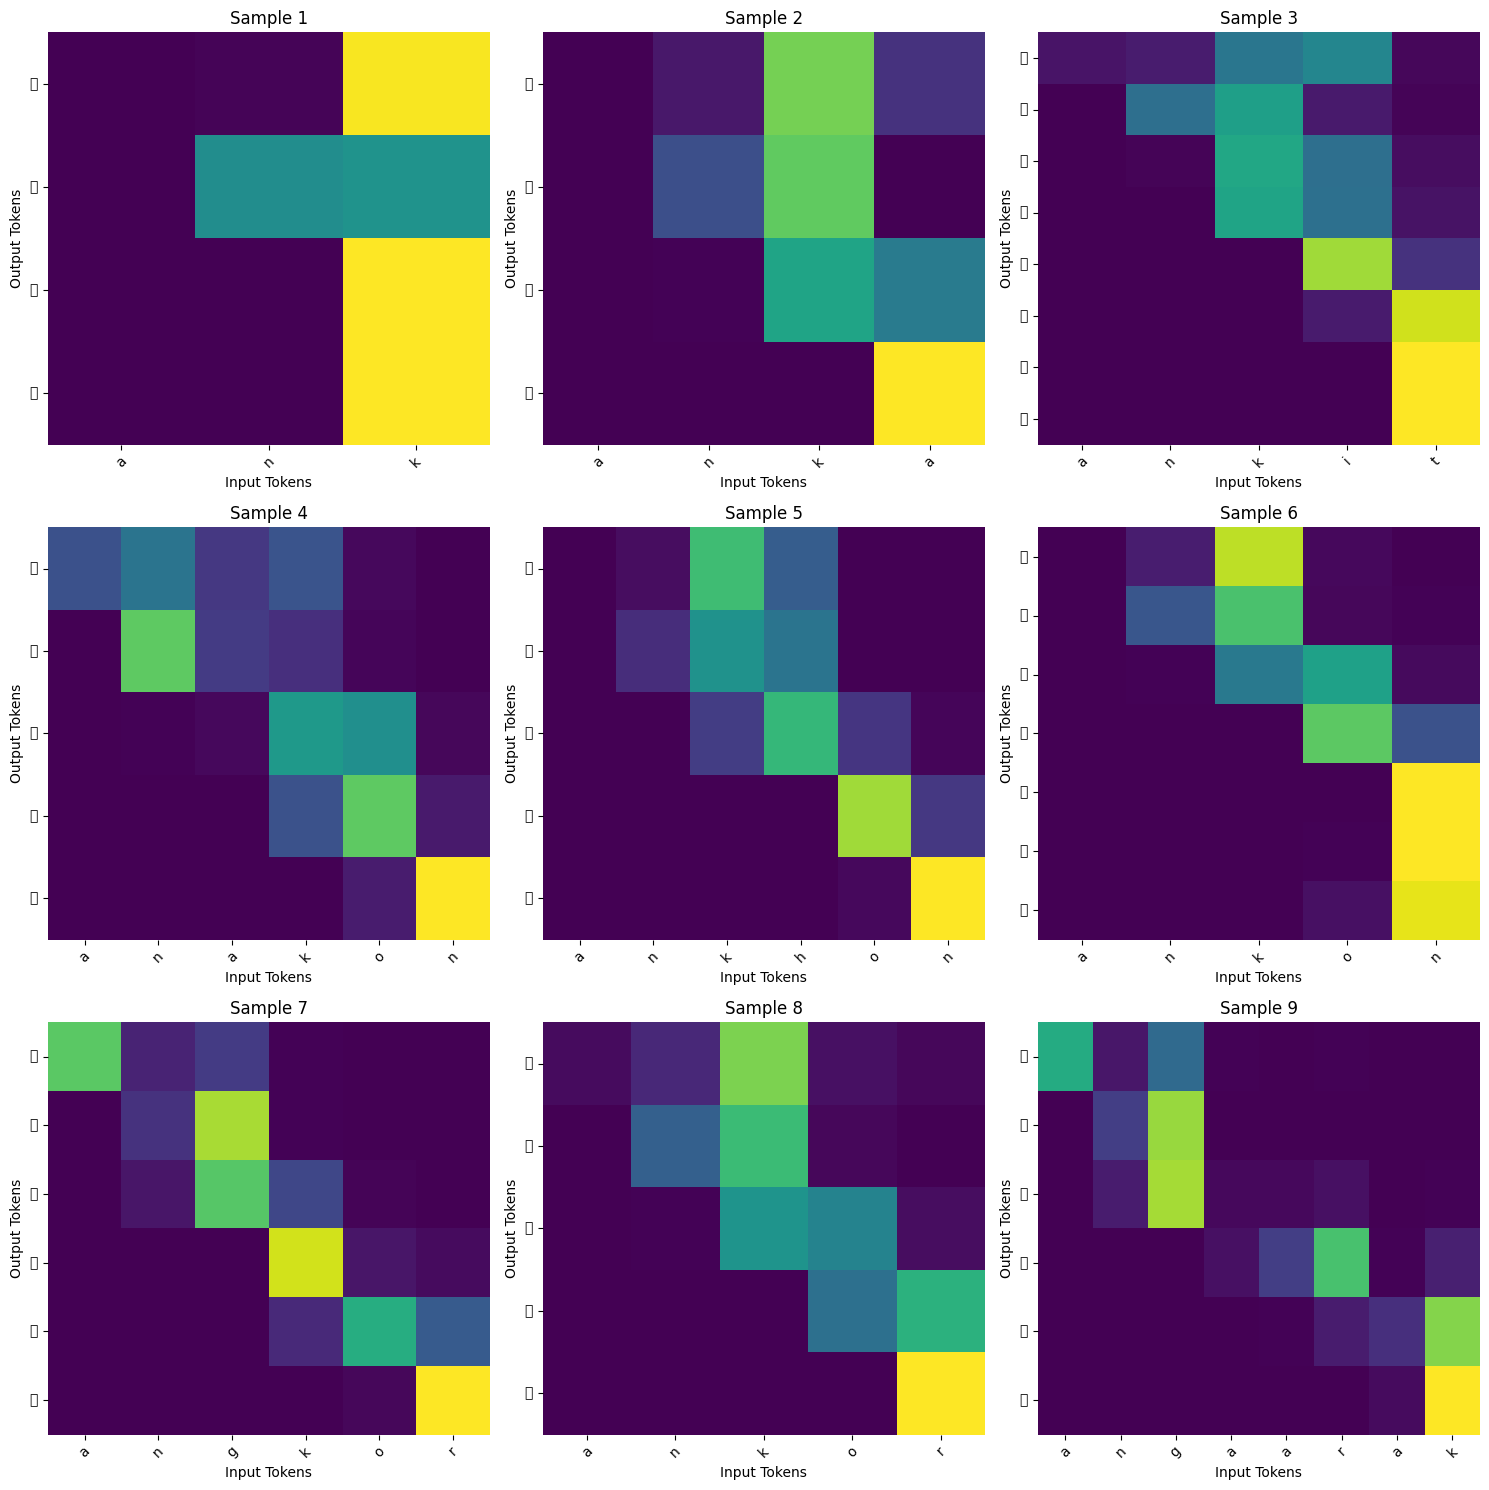

In [20]:
import json
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Load the JSON file
with open("/content/attention.json", "r") as f:
    data = json.load(f)

# Set up the 3x3 grid
fig, axes = plt.subplots(3, 3, figsize=(15, 15))

for i, ax in enumerate(axes.flat):
    if i >= len(data):
        ax.axis("off")
        continue

    sample = data[i]
    attention = np.array(sample["attention"])
    input_tokens = sample["input"]
    output_tokens = sample["output"]

    sns.heatmap(attention, ax=ax, cmap="viridis", xticklabels=input_tokens, yticklabels=output_tokens, cbar=False)

    ax.set_title(f"Sample {i+1}")
    ax.set_xlabel("Input Tokens")
    ax.set_ylabel("Output Tokens")
    ax.tick_params(axis='x', rotation=45)
    ax.tick_params(axis='y', rotation=0)

plt.tight_layout()
plt.show()

## Error Analysis

Once the predictions are obtained, error analysis is performed on them.

In [21]:
import pandas as pd

# Load predictions
df = pd.read_csv('predictions_vanilla/predictions_beam5.csv')

# Create a list of (src, pred, tgt) tuples
all_preds = list(zip(df['Input'], df['Prediction'], df['Target']))

🔍 Error Analysis:
Total sequence errors: 3473
Character-level consonant errors: 8665 (94.24%)
Character-level vowel errors: 530 (5.76%)
Errors in long sequences (≥ 7): 1003 (28.88%)

Top 10 confused character pairs (Target → Predicted):
र → ा: 176 times
ा → न: 124 times
ी → ि: 117 times
ट → त: 117 times
ा → र: 117 times
ि → ी: 101 times
ू → ु: 88 times
ा → त: 86 times
न → ा: 86 times
र → ्: 77 times


<ipython-input-22-c49bd1ef11e7>:72: UserWarning: Glyph 2352 (\N{DEVANAGARI LETTER RA}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-22-c49bd1ef11e7>:72: UserWarning: Matplotlib currently does not support Devanagari natively.
  plt.tight_layout()
<ipython-input-22-c49bd1ef11e7>:72: UserWarning: Glyph 2366 (\N{DEVANAGARI VOWEL SIGN AA}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-22-c49bd1ef11e7>:72: UserWarning: Glyph 2344 (\N{DEVANAGARI LETTER NA}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-22-c49bd1ef11e7>:72: UserWarning: Glyph 2368 (\N{DEVANAGARI VOWEL SIGN II}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-22-c49bd1ef11e7>:72: UserWarning: Glyph 2367 (\N{DEVANAGARI VOWEL SIGN I}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-22-c49bd1ef11e7>:72: UserWarning: Glyph 2335 (\N{DEVANAGARI LETTER TTA}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipytho

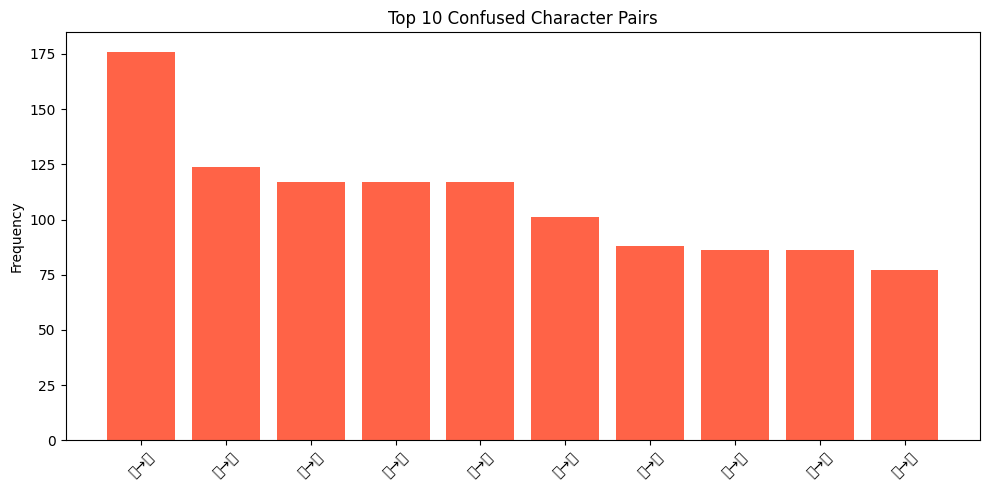

In [22]:
from collections import defaultdict
import matplotlib.pyplot as plt

# --- Define Hindi vowels (Devanagari script)
hindi_vowels = set('अआइईउऊएऐओऔऋॠऌॡॲऑऍ')

def is_vowel(ch):
    """Check if a Hindi character is a vowel."""
    return ch in hindi_vowels

# --- Initialize counters
consonant_errors = 0
vowel_errors = 0
long_seq_errors = 0
total_errors = 0
total_long = 0
char_confusions = defaultdict(int)

# --- Length threshold for long sequences
LONG_THRESHOLD = 7

# --- all_preds should be a list of (source, predicted, target) tuples
# Example:
# all_preds = [('english_word1', 'prediction1', 'groundtruth1'), ...]

for src, pred, tgt in all_preds:
    if pred != tgt:
        total_errors += 1

        if len(tgt) >= LONG_THRESHOLD:
            long_seq_errors += 1

        # Always increment total_long for long target sequences
        if len(tgt) >= LONG_THRESHOLD:
            total_long += 1

        # --- Analyze character-level mismatches
        for p, t in zip(pred, tgt):
            if p != t:
                if is_vowel(t):
                    vowel_errors += 1
                else:
                    consonant_errors += 1
                char_confusions[(t, p)] += 1

# --- Summary calculations
total_char_errors = vowel_errors + consonant_errors

print("🔍 Error Analysis:")
print(f"Total sequence errors: {total_errors}")
print(f"Character-level consonant errors: {consonant_errors} ({(consonant_errors/total_char_errors)*100:.2f}%)")
print(f"Character-level vowel errors: {vowel_errors} ({(vowel_errors/total_char_errors)*100:.2f}%)")
print(f"Errors in long sequences (≥ {LONG_THRESHOLD}): {long_seq_errors} ({(long_seq_errors/total_errors)*100:.2f}%)")

# --- Top confused character pairs
sorted_confusions = sorted(char_confusions.items(), key=lambda x: -x[1])[:10]

print("\nTop 10 confused character pairs (Target → Predicted):")
for (true_c, pred_c), count in sorted_confusions:
    print(f"{true_c} → {pred_c}: {count} times")

# --- Optional: Bar plot for top confusions
if sorted_confusions:
    chars, counts = zip(*sorted_confusions)
    labels = [f"{t}→{p}" for (t, p) in chars]

    plt.figure(figsize=(10, 5))
    plt.bar(labels, counts, color="tomato")
    plt.title("Top 10 Confused Character Pairs")
    plt.ylabel("Frequency")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()